In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("data/merged_data.csv")

In [3]:
data01 = data[~(data['VLAN'].astype(str).str.startswith('5') | (data['VLAN'] == 309) )]
data01 = data01[~((data01['year'] == 2024) & (data01['month'] < 9))]

In [4]:
data02 = data01[data01['month'].isin([9,10,11])]
data03 = data01[~data01['month'].isin([9,10,11])]
print(data02.shape)
print(data03.shape)

(187717, 43)
(93062, 43)


In [5]:
data02.drop(columns=['Unnamed: 0', 'VLAN', 'vlans', 'year', 'month'], inplace=True)
data03.drop(columns=['Unnamed: 0', 'VLAN', 'vlans', 'year', 'month'], inplace=True)

/var/folders/3n/q9jd5mfn313dc_nw5xr7htk40000gn/T/ipykernel_69063/2964776573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data02.drop(columns=['Unnamed: 0', 'VLAN', 'vlans', 'year', 'month'], inplace=True)
/var/folders/3n/q9jd5mfn313dc_nw5xr7htk40000gn/T/ipykernel_69063/2964776573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data03.drop(columns=['Unnamed: 0', 'VLAN', 'vlans', 'year', 'month'], inplace=True)


In [6]:
# Columns to one-hot encode
columns_to_encode = ['type', 'max_duration']

# One-hot encode the specified columns
df1 = pd.get_dummies(data02, columns=columns_to_encode, drop_first=False)
df2 = pd.get_dummies(data03, columns=columns_to_encode, drop_first=False)

In [7]:
df1.columns

Index(['tx_frame', 'jitter', 'latency', 'out_of_sequence', 'frame_loss',
       '401_402', '401_424', '402_sw14', '402_428', '402_411', '402_425',
       'sw14_430', '428_jax-sw01', 'jax-sw01_415', '411_414', '411_417',
       '417_420', '425_427', '424_410', '424_413', '424_429', '424_422',
       '410_416', '416_sao-sw04-p3', '416_sao-sw04-p31', 'sao-sw04-p3_405',
       'sao-sw04-p31_419', '429_412', '429_sw10', 'sw10_418',
       'sw10_pty-sw01-p6', 'pty-sw01-p6_423', '422_sju-sw03',
       'sju-sw03_pty-sw01-p1', 'pty-sw01-p1_421', '421_406', 'type_emix',
       'type_fx(9000)', 'max_duration_10', 'max_duration_30',
       'max_duration_50'],
      dtype='object')

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

In [16]:
drop = ['jitter', 'latency', 'out_of_sequence', 'frame_loss']
label = 'out_of_sequence'
# drop = label

In [17]:
# Separate features and labels
X_train = df1.drop(columns=drop).values
y_train = df1[label].values

X_test = df2.drop(columns=drop).values
y_test = df2[label].values

# Scale the features
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    
    # First hidden layer with L2 regularization, Batch Normalization, and Dropout
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(y_train_categorical.shape[1], activation='softmax')
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate for stability
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train_categorical, epochs=50, batch_size=32, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test_categorical, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
print(f"Predictions: {y_pred}")
print(f"True Labels: {y_test}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")


Epoch 1/50
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 6s 849us/step - accuracy: 0.8701 - loss: 0.4536
Epoch 2/50
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 5s 833us/step - accuracy: 0.9963 - loss: 0.0461
Epoch 3/50
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 5s 850us/step - accuracy: 0.9976 - loss: 0.0195
Epoch 4/50
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 5s 821us/step - accuracy: 0.9979 - loss: 0.0156
Epoch 5/50
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 5s 842us/step - accuracy: 0.9980 - loss: 0.0145
Epoch 6/50
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 5s 836us/step - accuracy: 0.9980 - loss: 0.0146
Epoch 7/50
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 5s 830us/step - accuracy: 0.9981 - loss: 0.0143
Epoch 8/50
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 5s 840us/step - accuracy: 0.9980 - loss: 0.0138
Epoch 9/50
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 5s 841us/step - accuracy: 0.9981 - loss: 0.0133
Epoch 10/50
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 5s 855us/step - accuracy: 0.9980 - loss: 0.0137
Epoch 11/50
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 5s 849us/step - accuracy: 0.9984 - loss: 0.0121
Epoch 12

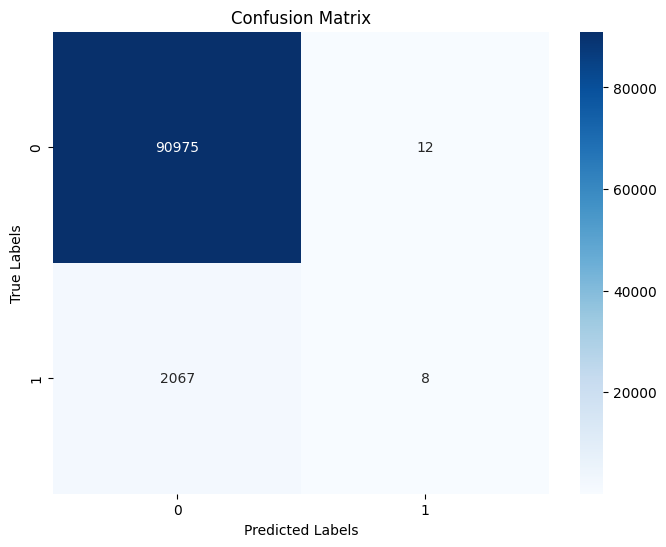

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

